In [179]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import matplotlib.patches as mpatches
from lifelines.utils import concordance_index
import scipy
from scipy import stats
from scipy.stats import linregress
from scipy.special import gamma

fontsize = 14
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
legend_size =14
plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

font = {'family': 'normal',
        'weight': 'bold',
        'size': 24}

plt.rc('font', **font)
params = {'legend.fontsize': 'x-large',
          # 'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams.update(params)
import seaborn as sns
import pandas
sns.set_style('white')
sns.set_context('paper')
sns.set()
np.random.seed(31415)

In [236]:
#
alpha = "100" # selected from best validation according to evaluation_model_selection.ipynb
noisy = False

model = 'CSA-INFO'
is_non_param = True
is_stochastic = True

if 'SR' in model:
    is_stochastic = False
    
if 'AFT' in model:
    is_non_param = False      
    
data = 'actg175_simulated'
#data = 'framingham'
#data = 'simulated'
#data = 'framingham_simulated'
#data = 'actg175_simulated'
if alpha:
    main_path = 'analysis/{}/alpha_{}/'.format(data, alpha)
    path = 'analysis/{}/alpha_{}/{}/'.format(data, alpha, model)
else:
    path = 'analysis/{}/{}/'.format(data, model)
    main_path = 'analysis/{}/'.format(data)


#data = 'sythentic'
#path = 'analysis/{}/alpha_{}/{}/'.format(fld,alpha,  model)

print(path)
has_cf = True
if 'simulated' in data:
    time = 'days'
    is_simulated = True
else:
    is_simulated = False
    time = 'days'
if is_non_param:
    pred_t0_f = np.load(path + 'Test_pred_t0_F.npy')
    pred_t0_cf = np.load(path +  'Test_pred_t0_CF.npy')

    pred_t1_f = np.load(path +  'Test_pred_t1_F.npy')
    pred_t1_cf = np.load(path +  'Test_pred_t1_CF.npy')
    print("pred_t0_f: ", pred_t0_f.shape)
    print("pred_t0_cf: ", pred_t0_cf.shape)

    print("pred_t1_f: ", pred_t1_f.shape)
    print("pred_t1_cf: ", pred_t1_cf.shape)
    
    pred_c0_f = np.load(path + 'Test_pred_c0_F.npy')
    pred_c0_cf = np.load(path +  'Test_pred_c0_CF.npy')

    pred_c1_f = np.load(path +  'Test_pred_c1_F.npy')
    pred_c1_cf = np.load(path +  'Test_pred_c1_CF.npy')
    
    print("pred_c0_f: ", pred_c0_f.shape)
    print("pred_c0_cf: ", pred_c0_cf.shape)

    print("pred_c1_f: ", pred_c1_f.shape)
    print("pred_c1_cf: ", pred_c1_cf.shape)
    
else:
    pred_t0_f = pandas.read_csv(path + 'Test_pred_t0_F.csv')
    pred_t0_cf = pandas.read_csv(path +  'Test_pred_t0_CF.csv')

    pred_t1_f = pandas.read_csv(path +  'Test_pred_t1_F.csv')
    pred_t1_cf = pandas.read_csv(path +  'Test_pred_t1_CF.csv')
    
    print("pred_t0_f: ", pred_t0_f.shape,pred_t0_f.head())
    print("pred_t0_cf: ", pred_t0_cf.shape, pred_t0_cf.head())

    print("pred_t1_f: ", pred_t1_f.shape, pred_t1_f.head())
    print("pred_t1_cf: ", pred_t1_cf.shape, pred_t1_cf.head())



analysis/actg175_simulated/alpha_100/CSA-INFO/
pred_t0_f:  (95, 200)
pred_t0_cf:  (119, 200)
pred_t1_f:  (119, 200)
pred_t1_cf:  (95, 200)
pred_c0_f:  (95, 200)
pred_c0_cf:  (119, 200)
pred_c1_f:  (119, 200)
pred_c1_cf:  (95, 200)


In [237]:
if is_simulated:
    dir_path = 'data/{}/'.format(data)
    path_factual =  dir_path + 'event_pairs.csv' 
    path_covariates = dir_path +  'covariates.npy'
    path_treatment = dir_path + 'treatment.npy'
    print("path:{}".format(path_factual))
    data_frame = pandas.read_csv(path_factual)
    print("head of data:{}, data shape:{}".format(data_frame.head(), data_frame.shape))

    idx = np.load(dir_path + 'test_idx.npy')

    # Preprocess
    a = np.load(path_treatment)[idx]

    ## Factual
    y_f = data_frame[['y_f']]
    e_f = data_frame[['e_f']]
    t_f = data_frame[['t_f']]

    y_f = np.array(y_f).reshape(len(y_f))[idx]
    e_f = np.array(e_f).reshape(len(e_f))[idx]
    t_f = np.array(t_f).reshape(len(t_f))[idx]

    ## Counter Factual
    y_cf = data_frame[['y_cf']]
    e_cf = data_frame[['e_cf']]
    t_cf = data_frame[['t_cf']]

    y_cf = np.array(y_cf).reshape(len(y_cf))[idx]
    e_cf = np.array(e_cf).reshape(len(e_cf))[idx]
    t_cf = np.array(t_cf).reshape(len(t_cf))[idx]

    print("a: ", a.shape)

    print("y_cf: ", y_cf.shape)
    print("e_cf: ", e_cf.shape)
    print("t_cf: ", t_cf.shape)


    print("y_f: ", y_f.shape)
    print("e_f: ", e_f.shape)
    print("t_f: ", t_f.shape)

else:
    path_factual = 'data/{}/{}_test_idx.csv'.format(data, data)
    data_frame = pandas.read_csv(path_factual)
    ## Factual
    y_f = data_frame[['time']]
    e_f = data_frame[['event']]
    a = data_frame[['treatment']]
    
    y_f = np.array(y_f).reshape(len(y_f))
    e_f = np.array(e_f).reshape(len(e_f))
    a = np.array(a).reshape(len(a))
    
    ## Counter Factual
    y_cf = data_frame[['nn_cf_y']]
    e_cf = data_frame[['nn_cf_e']]
 

    y_cf = np.array(y_cf).reshape(len(y_cf))
    e_cf = np.array(e_cf).reshape(len(e_cf))
    
    
    print("a: ", a.shape)
    
    print("y_cf: ", y_cf.shape)
    print("e_cf: ", e_cf.shape)

    print("y_f: ", y_f.shape)
    print("e_f: ", e_f.shape)
    print("a=1", np.sum(a))
    print("y_f[a==1.0].shape", y_f[a==1].shape)

    




path:data/actg175_simulated/event_pairs.csv
head of data:           y_f  e_f          t_f         y_cf  e_cf         t_cf
0  1140.488694  0.0  1733.114899  1140.488694   0.0  1969.358559
1   625.680911  1.0   625.680911   690.841656   1.0   690.841656
2   636.127886  1.0   636.127886   105.180387   1.0   105.180387
3   998.481322  0.0  1224.011567   495.973914   1.0   495.973914
4  1025.358140  0.0  1150.589279  1025.358140   0.0  1866.658538, data shape:(2139, 6)
a:  (214,)
y_cf:  (214,)
e_cf:  (214,)
t_cf:  (214,)
y_f:  (214,)
e_f:  (214,)
t_f:  (214,)


# Compute ITE

emp_ite:  (214,)
pred_ite:  (214,)


/Users/paidamoyochapfuwa/.pyenv/versions/3.6.4/envs/csa_prod/lib/python3.6/site-packages/seaborn/categorical.py:483: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  **kws)
/Users/paidamoyochapfuwa/.pyenv/versions/3.6.4/envs/csa_prod/lib/python3.6/site-packages/seaborn/categorical.py:483: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  **kws)


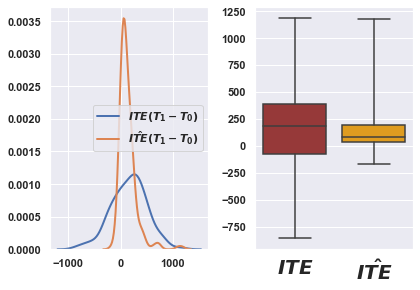

In [238]:
if is_simulated:
    emp_ite_t1 = t_f[a==1] - t_cf[a==1]
    emp_ite_t0 = t_cf[a==0] - t_f[a==0]
    emp_ite = np.concatenate((emp_ite_t1, emp_ite_t0), axis=0)
    print("emp_ite: ", emp_ite.shape)

    def weibull_mean(shape, scale):
        shape = np.exp(shape)
        scale = np.exp(scale)
        exp = 1 / shape
        pred_t = scale * gamma(1 + exp)
        return pred_t

    if is_non_param:
        pred_ite_t1 = np.mean(pred_t1_f,  axis=1) - np.mean(pred_t0_cf, axis=1)
        pred_ite_t0 = np.mean(pred_t1_cf,  axis=1) - np.mean(pred_t0_f, axis=1)
        pred_ite =  np.concatenate((pred_ite_t1, pred_ite_t0), axis=0)

    elif 'Weibull'  not in model:
        pred_ite_t1 = np.exp(pred_t1_f['mu_one']) - np.exp(pred_t0_cf['mu_zero'])
        pred_ite_t0 = np.exp(pred_t1_cf['mu_one']) - np.exp(pred_t0_f['mu_zero']) 
        pred_ite =  np.concatenate((pred_ite_t1, pred_ite_t0), axis=0)
    else:
        mean_pred_t1_f =  weibull_mean(shape=pred_t1_f['logshape_one'], scale=pred_t1_f['logscale_one'])
        mean_pred_t0_f =  weibull_mean(shape=pred_t0_f['logshape_zero'], scale=pred_t0_f['logscale_zero'])
    
        mean_pred_t0_cf =  weibull_mean(shape=pred_t0_cf['logshape_zero'], scale=pred_t0_cf['logscale_zero'])
        mean_pred_t1_cf =  weibull_mean(shape=pred_t1_cf['logshape_one'], scale=pred_t1_cf['logscale_one'])
    
        pred_ite_t1 =  mean_pred_t1_f - mean_pred_t0_cf
        pred_ite_t0 =  mean_pred_t1_cf - mean_pred_t0_f
        pred_ite =  np.concatenate((pred_ite_t1, pred_ite_t0), axis=0)
    
    print("pred_ite: ",pred_ite.shape)
       
               

    plt.subplot(1, 2, 1)
    plt.title('',  fontsize=fontsize)
    ax = sns.kdeplot(emp_ite,  lw=2, label='$ITE(T_1-T_0)$')
    ax = sns.kdeplot(pred_ite,  lw=2, label='$\hat{ITE}(T_1-T_0)$')
    plt.tight_layout()



    data = [emp_ite, pred_ite]
    plt.subplot(1, 2, 2)
    colors = ['brown', 'orange']
    ax = sns.boxplot(data=data, palette=colors, sym='o',
                     notch=0, whis='range', linewidth=1.5, showfliers=False)
    plt.title('',  fontsize=fontsize)
    plt.tight_layout()
    models = ['$ITE$', '$\hat{ITE}$']
    plt.xticks([0, 1], models, fontsize=20)


# Compute ATE 

In [239]:
if is_simulated:
    emp_ate = np.mean(emp_ite)
    pred_ate =np.mean(pred_ite)

    print("emp_ate: ", np.round(emp_ate, 2))
    print("pred_ate: ", np.round(pred_ate,2))
    print("Epsilon ATE: ", np.round(np.abs(emp_ate-pred_ate), 2))

emp_ate:  162.09
pred_ate:  130.9
Epsilon ATE:  31.19


# Compute PEHE

/Users/paidamoyochapfuwa/.pyenv/versions/3.6.4/envs/csa_prod/lib/python3.6/site-packages/seaborn/categorical.py:483: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  **kws)


Epsilon PEHE:  344.3


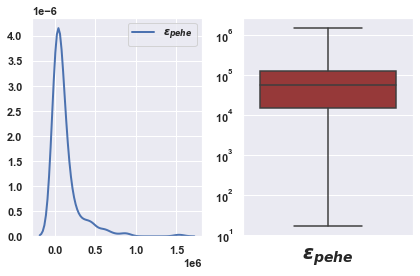

In [240]:
if is_simulated:
    pehe = (emp_ite-pred_ite)**2
    plt.subplot(1, 2, 1)
    plt.title('',  fontsize=fontsize)
    ax = sns.kdeplot(pehe,  lw=2, label='$\epsilon_{pehe}$')
    plt.tight_layout()


    data = [pehe]
    plt.subplot(1, 2, 2)
    colors = ['brown']
    ax = sns.boxplot(data=data, palette=colors, sym='o',
                     notch=0, whis='range', linewidth=1.5, showfliers=False)
    plt.title('',  fontsize=fontsize)
    plt.yscale('log')
    plt.tight_layout()
    models = ['$\epsilon_{pehe}$']
    plt.xticks([0], models, fontsize=20)

    print("Epsilon PEHE: ", np.round(np.sqrt(np.mean(pehe)), 2))

# SAMPLE

In [241]:
def sample_normal(mu, logvar, samples =200):
    sigma = np.exp(logvar * 0.5)
    gen_t = [np.random.normal(mu[i], sigma[i], samples) for i in np.arange(len(mu))]
    return np.exp(gen_t)

def sample_weibull(shape, scale, samples=200):
    u = np.random.uniform(0,1, size=(samples))
    lam = np.exp(scale)
    k = np.exp(shape)
    exponent = 1 / k
    gen_t = [lam[i] * ((-np.log(u)) ** exponent[i]) for i in np.arange(len(shape))]
    return np.array(gen_t)

if model == 'AFT' or model == 'AFT-KM':
    pred_t1_f = sample_normal(mu=pred_t1_f['mu_one'], logvar=pred_t1_f['logvar_one'])
    pred_t1_cf = sample_normal(mu=pred_t1_cf['mu_one'], logvar=pred_t1_cf['logvar_one'])

    pred_t0_f = sample_normal(mu=pred_t0_f['mu_zero'], logvar=pred_t0_f['logvar_zero'])
    pred_t0_cf = sample_normal(mu=pred_t0_cf['mu_zero'], logvar=pred_t0_cf['logvar_zero'])

    print("pred_t1_f: ", pred_t1_f.shape)
    print("pred_t1_cf: ", pred_t1_cf.shape)

    print("pred_t0_f: ", pred_t0_f.shape)
    print("pred_t0_cf: ", pred_t0_cf.shape)
    
elif model == 'AFT-Weibull' or model =='AFT-Weibull-KM' :
    pred_t1_f = sample_weibull(shape=pred_t1_f['logshape_one'], scale=pred_t1_f['logscale_one'])
    pred_t1_cf = sample_weibull(shape=pred_t1_cf['logshape_one'], scale=pred_t1_cf['logscale_one'])

    pred_t0_f = sample_weibull(shape=pred_t0_f['logshape_zero'], scale=pred_t0_f['logscale_zero'])
    pred_t0_cf = sample_weibull(shape=pred_t0_cf['logshape_zero'], scale=pred_t0_cf['logscale_zero'])

    print("pred_t1_f: ", pred_t1_f.shape)
    print("pred_t1_cf: ", pred_t1_cf.shape)

    print("pred_t0_f: ", pred_t0_f.shape)
    print("pred_t0_cf: ", pred_t0_cf.shape)

# Analysis

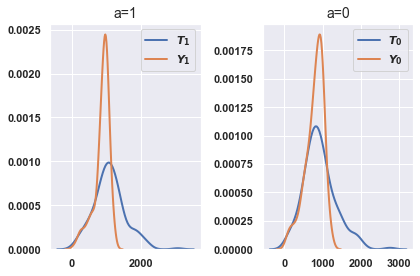

In [242]:
if is_simulated:
    plt.subplot(1, 2, 1)
    plt.title('a=1',  fontsize=fontsize)
    t1 = np.concatenate((t_f[a==1], t_cf[a==0]), axis=0)
    y1 = np.concatenate((y_f[a==1], y_cf[a==0]), axis=0)
    ax = sns.kdeplot(t1,  lw=2, label='$T_1$')
    ax = sns.kdeplot(y1,  lw=2, label='$Y_1$')
    plt.tight_layout()


    plt.subplot(1, 2, 2)
    plt.title('a=0',  fontsize=fontsize)
    t0 = np.concatenate((t_cf[a==1], t_f[a==0]), axis=0)
    y0 = np.concatenate((y_cf[a==1], y_f[a==0]), axis=0)
    ax = sns.kdeplot(t0,  lw=2, label='$T_0$')
    ax = sns.kdeplot(y0,  lw=2, label='$Y_0$')
    plt.tight_layout()

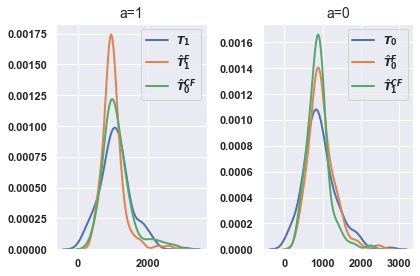

In [243]:
if is_simulated:
    plt.subplot(1, 2, 1)
    plt.title('a=1',  fontsize=fontsize)
    ax = sns.kdeplot(t1,  lw=2, label='$T_1$')
    ax = sns.kdeplot(np.median(pred_t1_f, axis=1),  lw=2, label='$\hat{T}_{1}^{F}$')
    ax = sns.kdeplot(np.median(pred_t1_cf, axis=1),  lw=2, label='$\hat{T}_{0}^{CF}$')
    plt.tight_layout()


    plt.subplot(1, 2, 2)
    plt.title('a=0',  fontsize=fontsize)
    ax = sns.kdeplot(t0,  lw=2, label='$T_0$')
    ax = sns.kdeplot(np.median(pred_t0_f, axis=1),  lw=2, label='$\hat{T}_{0}^{F}$')
    ax = sns.kdeplot(np.median(pred_t0_cf, axis=1),  lw=2, label='$\hat{T}_{1}^{CF}$')
    plt.tight_layout()

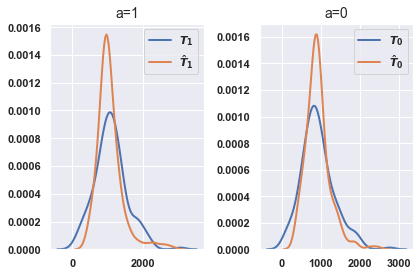

In [244]:
if is_simulated:
    plt.subplot(1, 2, 1)
    plt.title('a=1',  fontsize=fontsize)
    ax = sns.kdeplot(t1,  lw=2, label='$T_1$')
    pred_t1 = np.concatenate((pred_t1_f, pred_t1_cf), axis=0)
    ax = sns.kdeplot(np.median(pred_t1, axis=1),  lw=2, label='$\hat{T}_1$')
    plt.tight_layout()


    plt.subplot(1, 2, 2)
    plt.title('a=0',  fontsize=fontsize)
    ax = sns.kdeplot(t0,  lw=2, label='$T_0$')
    pred_t0 = np.concatenate((pred_t0_cf, pred_t0_f), axis=0)
    ax = sns.kdeplot(np.median(pred_t0, axis=1),  lw=2, label='$\hat{T}_0$')
    plt.tight_layout()

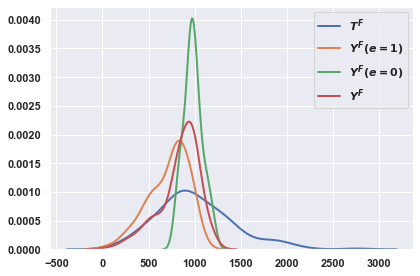

In [245]:
if is_simulated:
    ax = sns.kdeplot(t_f,  lw=2, label='$T^F$')
    ax = sns.kdeplot(y_f[e_f==1],  lw=2, label='$Y^F(e=1)$')
    ax = sns.kdeplot(y_f[e_f==0],  lw=2, label='$Y^F(e=0)$')
    ax = sns.kdeplot(y_f, lw=2, label='$Y^F$')
    plt.tight_layout()


# Factual Fit

## Compute C-Index

In [246]:
print(pred_t1_f.shape, y_f[a == 1].shape, e_f[a==1].shape)
c_index_1 = concordance_index(event_times=y_f[a == 1],
                                   predicted_event_times=np.median(pred_t1_f, axis=1),
                                   event_observed=e_f[a==1])
c_index_0 = concordance_index(event_times=y_f[a == 0],
                                   predicted_event_times=np.median(pred_t0_f, axis=1),
                                   event_observed=e_f[a==0])

y_all = np.concatenate((y_f[a==0], y_f[a==1]), axis=0)
e_all = np.concatenate((e_f[a==0], e_f[a==1]), axis=0)
a_all = np.concatenate((a[a==0], a[a==1]), axis=0)

pred_t_all = np.concatenate((pred_t0_f, pred_t1_f), axis=0)

c_index_all = concordance_index(event_times=y_all,
                                   predicted_event_times=np.median(pred_t_all, axis=1),
                                   event_observed=e_all)

print("c_index_0: ", np.round(c_index_0, 3), "c_index_1: ", np.round(c_index_1, 3), 
      "average: ", (c_index_1 + c_index_0) * 0.5, "all: ", c_index_all)

(119, 200) (119,) (119,)
c_index_0:  0.78 c_index_1:  0.764 average:  0.772345059880972 all:  0.7744187422351062


# Compute COV

cov:  0.13


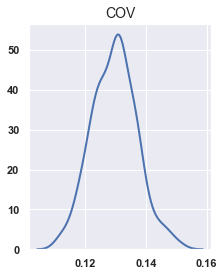

In [247]:
mu = np.mean(pred_t_all, axis=1)
std =  np.std(pred_t_all, axis=1)
cov = std/mu
plt.subplot(1, 2, 1)
plt.title('COV',  fontsize=fontsize)
ax = sns.kdeplot(cov,  lw=2)
plt.tight_layout()
print("cov: ", np.round(np.mean(cov),3))

## KM estimator

/Users/paidamoyochapfuwa/.pyenv/versions/3.6.4/envs/csa_prod/lib/python3.6/site-packages/lifelines/fitters/kaplan_meier_fitter.py:78: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self.confidence_interval_ = self._bounds(cumulative_sq_[:, None], alpha, ci_labels)
/Users/paidamoyochapfuwa/.pyenv/versions/3.6.4/envs/csa_prod/lib/python3.6/site-packages/lifelines/fitters/kaplan_meier_fitter.py:78: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self.confidence_interval_ = self._bounds(cumulative_sq_[:, None], alpha, ci_labels)


1013.409697    0.356073
1123.162535    0.328683
815.152816     0.642105
470.866571     0.915789
778.046887     0.665252
                 ...   
1190.909999    0.328683
928.670070     0.441037
595.954468     0.844211
727.705204     0.717321
720.859572     0.736842
Name: KM_estimate, Length: 214, dtype: float64 [0.35607321 0.32868296 0.64210526 0.91578947 0.66525193 0.32868296
 0.53455363 0.37701869 0.95789474 0.83304811]


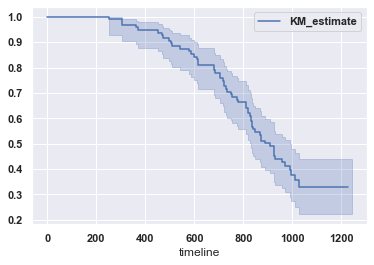

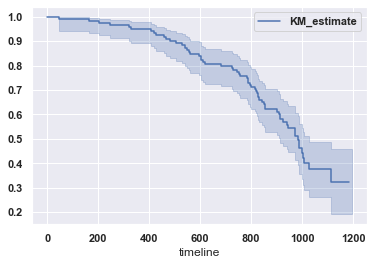

In [248]:
kmf_0 = KaplanMeierFitter()
kmf_0.fit(y_f[a==0], event_observed=e_f[a==0])  
kmf_0.median_
kmf_0.plot()

kmf_1 = KaplanMeierFitter()
kmf_1.fit(y_f[a==1], event_observed=e_f[a==1])  
kmf_1.median_
kmf_1.plot()

est = kmf_0.predict(y_f)
print(est, np.array(est)[0:10])


In [249]:
def compute_km(kmf, emp):
    range_quant = np.arange(start=0, stop=1.010, step=0.010)
    #t_emp_range = np.unique(np.sort(np.append(emp, [0])))
    t_emp_range = np.unique(np.sort(np.append(y_f, [0])))
    km_prob = [kmf.predict(i) for i in t_emp_range]
    inv_km = 1 - np.array(km_prob)
    return inv_km, t_emp_range

In [250]:
#Bounds
def ci_bounds(surv_t,cumulative_sq_,  alpha=0.95):
    #print("surv_t: ", surv_t, "cumulative_sq_: ", cumulative_sq_)
    # This method calculates confidence intervals using the exponential Greenwood formula.
    # See https://www.math.wustl.edu/%7Esawyer/handouts/greenwood.pdf
    #alpha = 0.95 
    if surv_t > 0.999:
        surv_t = 1
        cumulative_sq_ = 0
    alpha = 0.95
    constant = 1e-8
    alpha2 = stats.norm.ppf((1. + alpha) / 2.)
    v = np.log(surv_t)
    left_ci = np.log(-v)
    right_ci = alpha2 * np.sqrt(cumulative_sq_) * 1/v

    c_plus = left_ci + right_ci
    c_neg = left_ci - right_ci
    
    ci_lower = np.exp(-np.exp(c_plus))
    ci_upper = np.exp(-np.exp(c_neg))
       
    return [ci_lower, ci_upper]

In [251]:
def compute_km_det(pred_t, t_empirical_range, event):
    km_dead = []
    km_var = []
    km_sum = 0
    km_surv = 1
    km_ci = []
    hazard = []

    e_obs = event ==1
    #assert(len(pred_t) == len(empirical))
    assert(len(event) == len(pred_t))
    for j in np.arange(len(t_empirical_range)):
        high = t_empirical_range[j]
        low = 0 if j ==0 else t_empirical_range[j-1]
        #print("high: ", high, "low: ", low)

        in_range =  np.logical_and(pred_t < high, pred_t >=low)
        #print("in_range: ", np.sum(in_range))
        past = pred_t < low
        at_risk =  len(pred_t) - np.sum(past)
        #print("at_risk: ", at_risk)
        
        died = np.logical_and(in_range, e_obs)
        #print("died: ", np.sum(died))
        count_death  = np.sum(died)
        #print("count_death: ", count_death)
        if at_risk == 0:
            km_int_sum = 0
            km_int_surv = 1
        
        else:
            km_int_surv = 1 - count_death/at_risk 
            km_int_sum = count_death / (at_risk * (at_risk - count_death))
        
        km_surv = km_surv * km_int_surv
        if km_surv == 0:
            km_surv += 1e-8
        km_sum = km_sum +  km_int_sum
        km_ci.append(ci_bounds(cumulative_sq_=km_sum, surv_t=km_surv))
        hazard.append(count_death/at_risk)
    
       
    
        km_dead.append(1-km_surv)
        km_var.append(km_surv * km_surv * km_sum)
        
    
    print("km_surv: ", km_surv)

    #assert(len(km_dead) == len(empirical_dead))
    return np.array(km_dead), np.array(km_var),np.array(km_ci), np.array(hazard)

In [252]:
#Population wise cdf 
def compute_km_dist(predicted_samples, t_empirical_range, event, observed=None):
    km_dead = []
    km_surv = 1
    hazard = []
    
    km_var = []
    km_ci = []
    km_sum = 0
    
    kernel = []
    e_event = event
    
    if observed:
        predicted_samples = predicted_samples[event==1]
        e_event = e_event[event_test==1]
        
            
    for j in np.arange(len(t_empirical_range)):
        r = t_empirical_range[j]
        low = 0 if j ==0 else t_empirical_range[j-1]
        area = 0
        censored = 0
        dead = 0
        at_risk = len(predicted_samples)
        count_death = 0
        for i in np.arange(len(predicted_samples)):
            e = e_event[i]
            if len(kernel)!= len(predicted_samples):
                kernel_i = stats.gaussian_kde(predicted_samples[i]) 
                kernel.append(kernel_i)
            else:
                kernel_i = kernel[i]
            at_risk = at_risk - kernel_i.integrate_box_1d(low=0, high=low)
            
            if e == 1:
                count_death+= kernel_i.integrate_box_1d(low=low, high=r)
        if at_risk == 0:
            break
        km_int_surv = 1 - count_death/at_risk
        km_int_sum = count_death / (at_risk * (at_risk - count_death))
        hazard.append(count_death/at_risk)
        
        km_surv = km_surv * km_int_surv
        if km_surv == 0:
            km_surv += 1e-8
        km_sum = km_sum + km_int_sum
        
        km_ci.append(ci_bounds(cumulative_sq_=km_sum, surv_t=km_surv))
    
    
        km_dead.append(1-km_surv)
        km_var.append(km_surv * km_surv * km_sum)
      
    return np.array(km_dead), np.array(km_var), np.array(km_ci), np.array(hazard)

In [253]:

# calibration slope
def print_cal(predicted, model, empirical):
    slope, intercept, r_value, p_value, std_err = linregress(x=predicted, y=empirical)
    print( model, "slope: ", np.round(slope, 3), "intercept: ", intercept, "p_value: ", p_value, "std_err: ", std_err)

## Investigate Treatment A==0

In [254]:
inv_km_0, t_emp_range = compute_km(kmf=kmf_0, emp=y_f)
if is_stochastic:
   # inv_km_aft_0, km_var_aft_0, km_ci_aft_0, hazard_0 = compute_km_dist(pred_t0_f, t_empirical_range=t_emp_range_0,
                                                           #event=e_f[a==0])
    
    inv_km_aft_0, km_var_aft_0, km_ci_aft_0, hazard_0 = compute_km_det(np.median(pred_t0_f, axis=1),
                                                           t_empirical_range=t_emp_range,
                                                           event=e_f[a==0])
else:
    inv_km_aft_0, km_var_aft_0, km_ci_aft_0, hazard_0 = compute_km_det(np.median(pred_t0_f, axis=1),
                                                             t_empirical_range=t_emp_range,
                                                          event=e_f[a==0])
    

km_surv:  0.3553323237733504


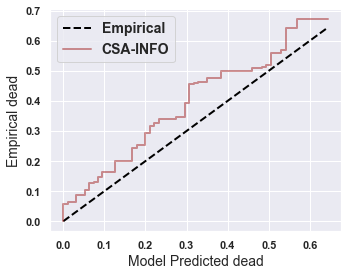

In [255]:
plt.figure(figsize=(5,4))
plt.plot(np.array(inv_km_aft_0),np.array(inv_km_aft_0), '--', color='black', lw=2, label='Empirical')
plt.step(x=np.array(inv_km_aft_0), y=np.array(inv_km_0), label=model, color='brown', lw=2, alpha=0.5)
plt.xlabel('Model Predicted dead',  fontsize=fontsize)
plt.ylabel('Empirical dead',  fontsize=fontsize)
plt.tight_layout()
plt.legend(loc='best', fontsize=legend_size)


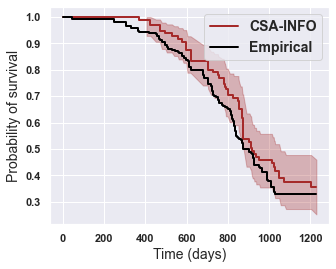

<Figure size 432x288 with 0 Axes>

In [256]:
fig=plt.figure(figsize=(5,4))
plt.xlabel("Time ({})".format(time),  fontsize=fontsize)
plt.ylabel("Probability of survival",  fontsize=fontsize)


plt.step(x = t_emp_range, y = 1-inv_km_aft_0, label=model, color='brown', lw=2)
plt.fill_between( t_emp_range, km_ci_aft_0[:, 0], km_ci_aft_0[:, 1], 
                 alpha=0.3, color='brown', linestyle="-", linewidth=1)

    
plt.step(x = t_emp_range, y = 1-inv_km_0, label='Empirical', color='black', lw=2)
plt.legend(loc='best', fontsize=legend_size)
plt.show()
plt.tight_layout()


In [257]:
print_cal(predicted=inv_km_aft_0, model=model + '_0', empirical=inv_km_0)

CSA-INFO_0 slope:  0.999 intercept:  0.06246225683350187 p_value:  1.3033950688688032e-174 std_err:  0.010715693036573807


## Investigate Treatment A == 1

In [258]:
inv_km_1,t_emp_range  = compute_km(kmf=kmf_1, emp=y_f)
if is_stochastic:
    #inv_km_aft_1, km_var_aft_1, km_ci_aft_1, hazard_1 = compute_km_dist(pred_t1_f, t_empirical_range=t_emp_range_1,
                                                           #event=e_f[a==1])
    
    inv_km_aft_1, km_var_aft_1, km_ci_aft_1, hazard_1 = compute_km_det(np.median(pred_t1_f, axis=1), 
                                                              t_empirical_range=t_emp_range,
                                                               event=e_f[a==1])
else:
     inv_km_aft_1, km_var_aft_1, km_ci_aft_1, hazard_1 = compute_km_det(np.median(pred_t1_f, axis=1), 
                                                              t_empirical_range=t_emp_range,
                                                           event=e_f[a==1])

km_surv:  0.45922351201529993


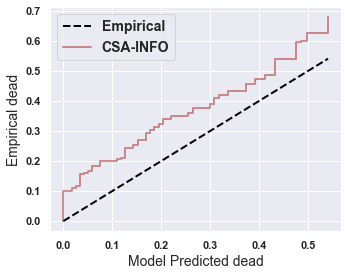

In [259]:
plt.figure(figsize=(5,4))
plt.plot(np.array(inv_km_aft_1),np.array(inv_km_aft_1), '--', color='black', lw=2, label='Empirical')
plt.step(x=np.array(inv_km_aft_1), y=np.array(inv_km_1), label=model, color='brown', lw=2, alpha=0.5)
plt.xlabel('Model Predicted dead',  fontsize=fontsize)
plt.ylabel('Empirical dead',  fontsize=fontsize)
plt.tight_layout()
plt.legend(loc='best', fontsize=legend_size)

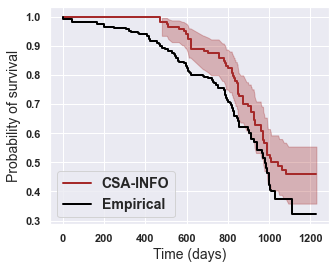

<Figure size 432x288 with 0 Axes>

In [260]:
fig=plt.figure(figsize=(5,4))
plt.xlabel("Time ({})".format(time),  fontsize=fontsize)
plt.ylabel("Probability of survival",  fontsize=fontsize)


plt.step(x = t_emp_range, y = 1-inv_km_aft_1, label=model, color='brown', lw=2)
plt.fill_between( t_emp_range, km_ci_aft_1[:, 0], km_ci_aft_1[:, 1], 
                 alpha=0.3, color='brown', linestyle="-", linewidth=1)

    
plt.step(x = t_emp_range, y = 1-inv_km_1, label='Empirical', color='black', lw=2)
plt.legend(loc='best', fontsize=legend_size)
plt.show()
plt.tight_layout()

In [261]:
print_cal(predicted=inv_km_aft_1, model=model +'_1', empirical=inv_km_1)

CSA-INFO_1 slope:  1.029 intercept:  0.08650032588976464 p_value:  2.3381588291770234e-186 std_err:  0.009696749103387007


# Plot ALL

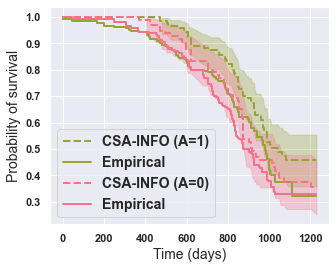

<Figure size 432x288 with 0 Axes>

In [262]:
colors = sns.color_palette("husl", 4)
fig=plt.figure(figsize=(5,4))
plt.xlabel("Time ({})".format(time),  fontsize=fontsize)
plt.ylabel("Probability of survival",  fontsize=fontsize)

## A=1
plt.step(x = t_emp_range, y = 1-inv_km_aft_1, label=model+' (A=1)', color=colors[1], lw=2, linestyle='--')
plt.fill_between( t_emp_range, km_ci_aft_1[:, 0], km_ci_aft_1[:, 1], 
                 alpha=0.3, color=colors[1], linestyle="-", linewidth=1)
    
plt.step(x = t_emp_range, y = 1-inv_km_1, label='Empirical', color=colors[1], lw=2)

## A=0
plt.step(x = t_emp_range, y = 1-inv_km_aft_0, label=model+' (A=0)', color=colors[0], lw=2, linestyle='--')
plt.fill_between( t_emp_range, km_ci_aft_0[:, 0], km_ci_aft_0[:, 1], 
                 alpha=0.3, color=colors[0], linestyle="-", linewidth=1)
plt.step(x = t_emp_range, y = 1-inv_km_0, label='Empirical', color=colors[0], lw=2)

plt.legend(loc='best', fontsize=legend_size)
plt.show()
plt.tight_layout()

slope:  -0.000844262795309695 std_err:  1.977695549184375e-05
slope:  -0.0007218423863023248 std_err:  2.0622690708098664e-05
slope:  -0.0008712893060952854 std_err:  1.595780117833588e-05
slope:  -0.0007713152140314167 std_err:  1.7434440731865574e-05


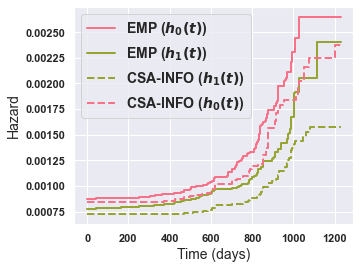

<Figure size 432x288 with 0 Axes>

In [263]:
def compute_grad(surv, time):
    slope, intercept, r_value, p_value, std_err = linregress(x=time, y=surv) # 
    print("slope: ", slope, "std_err: ", std_err)
    
    #gradient = [(y2-y0)/(x2-x0) for x2, x0, y2, y0 in zip(time[2:], time, surv[2:], surv)]
    

    return  slope
    
s_0_prime_est = compute_grad(surv=1-inv_km_aft_0, time=t_emp_range)
    
s_1_prime_est = compute_grad(surv=1-inv_km_aft_1, time=t_emp_range)

    
s_0_prime  = compute_grad(surv=1-inv_km_0, time=t_emp_range) 
s_1_prime  = compute_grad(surv=1-inv_km_1, time=t_emp_range)


colors = sns.color_palette("husl", 4)
fig=plt.figure(figsize=(5,4))
plt.xlabel("Time ({})".format(time),  fontsize=fontsize)
plt.ylabel("Hazard",  fontsize=fontsize)

plt.step(t_emp_range, -s_0_prime / (1-inv_km_0),  label='EMP ($h_0(t)$)', lw=2, color=colors[0])
plt.step(t_emp_range, -s_1_prime / (1-inv_km_1),  label='EMP ($h_1(t)$)', lw=2, color=colors[1])

plt.step(t_emp_range, -s_1_prime_est / (1-inv_km_aft_1),  label=model+' ($h_1(t)$)', lw=2, linestyle='--'
        , color=colors[1])
plt.step(t_emp_range, -s_0_prime_est / (1-inv_km_aft_0),  label=model+' ($h_0(t)$)', lw=2, linestyle='--',
        color=colors[0])



plt.legend(loc='best', fontsize=legend_size)
plt.show()
plt.tight_layout()



In [264]:
def hr_dist(hr, ms):
    perc_50 = np.round(np.percentile(hr, 50),2)
    perc_2_5 = np.round(np.percentile(hr, 2.5),2)
    perc_97_5 = np.round(np.percentile(hr, 97.5),2)
    print(ms, "{} ({}, {})".format(perc_50, perc_2_5, perc_97_5))

mean: HR EST Slope  0.75 (0.63, 0.85)
mean: EMP HR Slope  0.78 (0.69, 0.91)


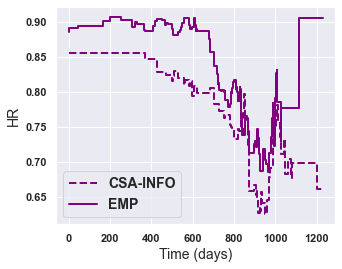

<Figure size 432x288 with 0 Axes>

In [265]:
colors = sns.color_palette("husl", 4)
fig=plt.figure(figsize=(5,4))
plt.xlabel("Time ({})".format(time),  fontsize=fontsize)
plt.ylabel("HR",  fontsize=fontsize)

## A=1
#plt.step(x = t_emp_range, y = hazard_1, label=model+' (A=1)', color=colors[1], lw=2, linestyle='--')  

## A=0
#plt.step(x = t_emp_range, y = hazard_0, label=model+' (A=0)', color=colors[0], lw=2, linestyle='--')

## HR
HR_est =(1-inv_km_aft_0)/(1-inv_km_aft_1) 
HR_est_slope= (1-inv_km_aft_0)/(1-inv_km_aft_1) * (s_1_prime_est /s_0_prime_est)

#hr_dist(HR_est, "mean: HR EST ")
hr_dist(HR_est_slope, "mean: HR EST Slope ")

#plt.step(x = t_emp_range, y =HR_est , label=model+' ($\hat{HR}$)', color='grey', lw=2, linestyle='--')
plt.step(x = t_emp_range, y =HR_est_slope , label=model, color='purple', lw=2, linestyle='--')


HR =(1-inv_km_0)/(1-inv_km_1) 
HR_slope= (1-inv_km_0)/(1-inv_km_1) * (s_1_prime /s_0_prime)


#hr_dist(HR, "mean: EMP HR ")
hr_dist(HR_slope, "mean: EMP HR Slope ")

#plt.step(x = t_emp_range, y =HR , label=model+' (HR)', color='grey', lw=2,)
plt.step(x = t_emp_range, y =HR_slope , label='EMP', color='purple', lw=2)



plt.legend(loc='best', fontsize=legend_size)
plt.show()
plt.tight_layout()



In [266]:
def compute_area():
    c1_curve = 1-inv_km_1
    c0_curve = 1-inv_km_0
    
    a1_curve = 1-inv_km_aft_1
    a0_curve = 1-inv_km_aft_0
    t_emp_range = np.unique(np.sort(np.append(y_f, [0])))
    
    area_1 = scipy.integrate.simps((c1_curve-a1_curve)**2,t_emp_range)
    print("AREA emp of s1 curves ", area_1)
    
   
    
    area_0 = scipy.integrate.simps((c0_curve-a0_curve)**2,t_emp_range)
    print("AREA approx of s0 curves", area_0)
    
    average = 0.5 * (area_1 + area_0)
    print("Average AREA diff",  average)
    
    all_Y_range = np.concatenate((np.expand_dims(t_emp_range, axis=1), np.expand_dims(t_emp_range, axis=1)), axis=1)
    t_emp_range = np.unique(np.sort(np.append(all_Y_range, [0])))
      
    c_area =  c1_curve-c0_curve
    a_area  = a1_curve-a0_curve
    area_diff  = scipy.integrate.simps((c_area-a_area)**2, t_emp_range)
    
    print("Average AREA between", area_diff)

In [267]:
compute_area()

AREA emp of s1 curves  9.207321306563328
AREA approx of s0 curves 3.8433138869349412
Average AREA diff 6.525317596749135
Average AREA between 1.943241646274612


# Causal Metrics

In [268]:

 N = len(a) 
if is_simulated:
    T_0 = np.concatenate((t_f[a==0], t_cf[a==1]), axis=0)
    T_1 = np.concatenate((t_f[a==1], t_cf[a==0]), axis=0)

    all_T = np.concatenate((T_0, T_1), axis=0)

    assert len(T_0) == len(T_1)
    assert len(all_T) == N *2
    
if is_simulated or has_cf:
    
    e_0 = np.concatenate((e_f[a==0], e_cf[a==1]), axis=0)
    e_1 = np.concatenate((e_f[a==1], e_cf[a==0]), axis=0)
    all_e = np.concatenate((e_0, e_1), axis=0)

    all_a = np.concatenate((np.zeros(N), np.ones(N)), axis=0)

    assert len(e_0) == N
    assert len(e_1) == N

    assert len(all_a) == N*2
    assert len(all_e) == N*2

In [269]:
if is_simulated or has_cf:
    T_0_pred = np.concatenate((np.median(pred_t0_f, axis=1), np.median(pred_t0_cf, axis=1)), axis=0)
    T_1_pred = np.concatenate((np.median(pred_t1_f, axis=1), np.median(pred_t1_cf, axis=1)), axis=0)

    all_T_pred = np.concatenate((T_0_pred, T_1_pred), axis=0)

    #assert len(T_0_pred) == len(T_0)
    assert len(T_1_pred) == len(T_0_pred)
    assert len(all_T_pred) == len(T_0_pred)*2
    
else:
    T_0_pred  = np.median(pred_t0_f, axis=1)
    T_1_pred = np.median(pred_t1_f, axis=1)
    all_T_pred = np.concatenate((T_0_pred, T_1_pred), axis=0)
    
    



In [270]:
if is_simulated or has_cf:
    Y_0 = np.concatenate((y_f[a==0], y_cf[a==1]), axis=0)
    Y_1 = np.concatenate((y_f[a==1], y_cf[a==0]), axis=0)

    all_Y = np.concatenate((Y_0, Y_1), axis=0)

    assert len(Y_0) == len(a)
    assert len(Y_1) == len(a)
    assert len(all_Y) == len(a) *2

else:
    Y_0 = y_f[a==0]
    Y_1 = y_f[a==1]
    all_Y = np.concatenate((Y_0, Y_1), axis=0)
    all_e = np.concatenate((e_f[a==0], e_f[a==1]), axis=0)
    all_a = np.concatenate((a[a==0], a[a==1]), axis=0)

    


In [271]:
#t_emp_range = np.unique(np.sort(np.append(all_T, [0])))
#all_Y_range = np.concatenate((np.expand_dims(t_emp_range_0, axis=1), np.expand_dims(t_emp_range_1, axis=1)), axis=1)
#t_emp_range = np.unique(np.sort(np.append(all_Y_range, [0])))

def compute_area(curves, c0, c1, a0, a1, t_emp_range):
    c1_curve = curves[c1].predict(t_emp_range)
    c0_curve = curves[c0].predict(t_emp_range)
    
    a1_curve = curves[a1].predict(t_emp_range)
    a0_curve = curves[a0].predict(t_emp_range)
    
    area_1 = scipy.integrate.simps((c1_curve-a1_curve)**2,t_emp_range)
    print("AREA emp of ({} - {})**2 ".format(c1, a1), area_1)
    
   
    
    area_0 = scipy.integrate.simps((c0_curve-a0_curve)**2,t_emp_range)
    print("AREA approx of ({} - {})**2 ".format(c0, a0), area_0)
    
    average = 0.5 * (area_1 + area_0)
    print("Average AREA diff",  average)
    
      
    c_area =  c1_curve-c0_curve
    a_area  = a1_curve-a0_curve
    area_diff  = scipy.integrate.simps((c_area-a_area)**2, t_emp_range)
    
    print("Average AREA between squared diff", area_diff)
                            

In [272]:
def km_estimator(data_1, data_2):
    handles = []
    colors = sns.color_palette("husl", 4)
    fig = plt.figure(figsize=(8, 8))
    #fig = plt.figure(figsize=(11, 17))
    ax = fig.add_subplot(211)
    
    T = data_1['T']
    delta = data_1['delta']
    name = data_1['name']
    A = data_1['A']
    fact = data_1['fact']
    choice = ['0', '1']
    curves = {}
    for i, c in enumerate(np.arange(2)):
        kmf = KaplanMeierFitter()
        idx_c = A == c
        cluster_t = T[idx_c]
        cluster_e = delta[idx_c]
        key = name + choice[c] + fact
        #handles.append(mpatches.Patch(color=colors[c], label= "${}_{}^{}$ ({})".format(name, c, fact,  len(cluster_t))))
        handles.append(mpatches.Patch(color=colors[c], 
                                      label= "${}_{}^{} ({})$".format(name,  choice[c], fact, len(cluster_t))))
        observed = cluster_e == 1
        observed_t = cluster_t[observed]
        kmf.fit(cluster_t, event_observed=observed, label=c)
        curves[key] = kmf
        kmf.survival_function_.plot(ax=ax, color=colors[c], lw=2)
    
    if data_2:
        
        
        T = data_2['T']
        delta = data_2['delta']
        name = data_2['name']
        A = data_2['A']
        fact = data_2['fact']
    
        for i, c in enumerate(np.arange(2)):
            kmf = KaplanMeierFitter()
            idx_c = A == c
            cluster_t = T[idx_c]
            cluster_e = delta[idx_c]
            if name == 'Y(e=1)':
                key = 'Y_nc' + choice[c] + fact
                handles.append(mpatches.Patch(color=colors[c], linestyle='--',
                                          label="$Y(\delta=1)^{}_{} ({})$".format(fact, c, len(cluster_t))))
            else:
                key = name + choice[c] + fact
                handles.append(mpatches.Patch(color=colors[c], linestyle='--',
                                          label="${}^{}_{} ({})$".format(name, fact, c, len(cluster_t))))
            observed = cluster_e == 1
            observed_t = cluster_t[observed]
            kmf.fit(cluster_t, event_observed=observed, label=c)
            curves[key] = kmf
            kmf.survival_function_.plot(ax=ax, color=colors[c], lw=2, linestyle='--')
            
     
  
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.legend(handles=handles, loc='best', fontsize=14)
    plt.ylabel("Probability of survival", fontsize=fontsize)
    plt.tight_layout()
    plt.xlabel("Time ({})".format(time), fontsize=fontsize)
    
    return curves

/Users/paidamoyochapfuwa/.pyenv/versions/3.6.4/envs/csa_prod/lib/python3.6/site-packages/lifelines/fitters/kaplan_meier_fitter.py:78: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self.confidence_interval_ = self._bounds(cumulative_sq_[:, None], alpha, ci_labels)
/Users/paidamoyochapfuwa/.pyenv/versions/3.6.4/envs/csa_prod/lib/python3.6/site-packages/lifelines/fitters/kaplan_meier_fitter.py:78: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self.confidence_interval_ = self._bounds(cumulative_sq_[:, None], alpha, ci_labels)
/Users/paidamoyochapfuwa/.pyenv/versions/3.6.4/envs/csa_prod/lib/python3.6/site-packages/lifelines/fitters/kaplan_meier_fitter.py:78: FutureWarning: Support for multi-dimensional indexing (e.g. `o

{'T0A': <lifelines.KaplanMeierFitter: fitted with 214 observations, 0 censored>, 'T1A': <lifelines.KaplanMeierFitter: fitted with 214 observations, 0 censored>, 'T0M': <lifelines.KaplanMeierFitter: fitted with 214 observations, 80 censored>, 'T1M': <lifelines.KaplanMeierFitter: fitted with 214 observations, 120 censored>}
t_emp_range max, min:  3040.099968093928 0.0
AREA emp of (T1A - T1M)**2  259.6312096854866
AREA approx of (T0A - T0M)**2  85.4137105620402
Average AREA diff 172.5224601237634
Average AREA between squared diff 49.99123897610211


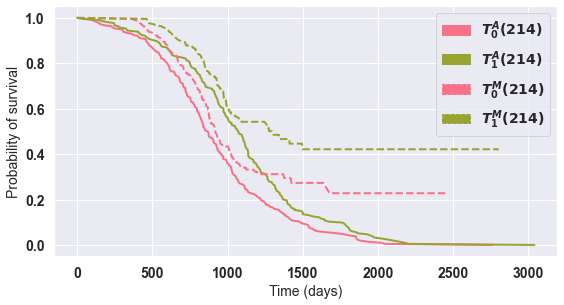

In [273]:
if is_simulated:
    all_true = {'T':all_T , 'delta': np.ones(N*2), 'A': all_a, 'name': 'T', 'fact': 'A'}
    all_pred = {'T': all_T_pred, 'delta': all_e, 'A': all_a, 'name': 'T', 'fact': 'M' }

    curves = km_estimator(data_1=all_true, data_2=all_pred)
    print(curves)

    t_emp_range = np.unique(np.sort(np.append(all_T, [0])))
    print("t_emp_range max, min: ", np.max(t_emp_range), np.min(t_emp_range))
    compute_area(curves=curves, c0='T0A', c1='T1A', a0='T0M', a1='T1M', t_emp_range=t_emp_range)

## Estimate Hazard

(428,) (428,) (428,) (428,)


/Users/paidamoyochapfuwa/.pyenv/versions/3.6.4/envs/csa_prod/lib/python3.6/site-packages/lifelines/fitters/kaplan_meier_fitter.py:78: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self.confidence_interval_ = self._bounds(cumulative_sq_[:, None], alpha, ci_labels)
/Users/paidamoyochapfuwa/.pyenv/versions/3.6.4/envs/csa_prod/lib/python3.6/site-packages/lifelines/fitters/kaplan_meier_fitter.py:78: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self.confidence_interval_ = self._bounds(cumulative_sq_[:, None], alpha, ci_labels)
/Users/paidamoyochapfuwa/.pyenv/versions/3.6.4/envs/csa_prod/lib/python3.6/site-packages/lifelines/fitters/kaplan_meier_fitter.py:78: FutureWarning: Support for multi-dimensional indexing (e.g. `o

{'Y0A': <lifelines.KaplanMeierFitter: fitted with 214 observations, 80 censored>, 'Y1A': <lifelines.KaplanMeierFitter: fitted with 214 observations, 120 censored>, 'T0M': <lifelines.KaplanMeierFitter: fitted with 214 observations, 80 censored>, 'T1M': <lifelines.KaplanMeierFitter: fitted with 214 observations, 120 censored>}
t_emp_range max, min:  1229.1075123259275 0.0
AREA emp of (Y1A - T1M)**2  5.892703984919172
AREA approx of (Y0A - T0M)**2  5.287340896975112
Average AREA diff 5.590022440947142
Average AREA between squared diff 0.4678677893015484


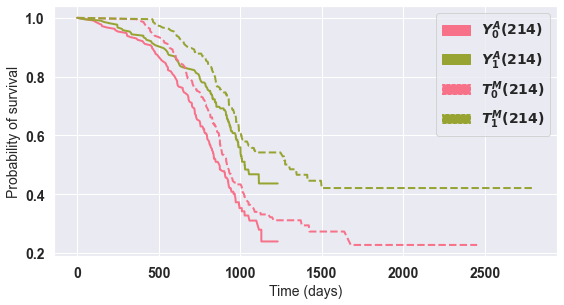

In [274]:
all_true_Y = {'T':all_Y , 'delta': all_e, 'A': all_a, 'name': 'Y', 'fact': 'A'}
all_pred = {'T': all_T_pred, 'delta': all_e, 'A': all_a, 'name': 'T', 'fact': 'M' }
print(all_T_pred.shape, all_Y.shape, all_e.shape, all_a.shape)

curves = km_estimator(data_1=all_true_Y, data_2=all_pred)
print(curves)

t_emp_range = np.unique(np.sort(np.append(all_Y, [0])))
print("t_emp_range max, min: ", np.max(t_emp_range), np.min(t_emp_range))

compute_area(curves=curves, c0='Y0A', c1='Y1A', a0='T0M', a1='T1M', t_emp_range=t_emp_range)

km_surv:  0.3119731598272776
km_surv:  0.5427267057473502
slope:  -0.0008351534314675858 std_err:  1.3269341575783774e-05
slope:  -0.0005619598316284906 std_err:  1.2371379894744969e-05
CSA-INFO mean: HR EST Slope  0.53 (0.41, 0.67)


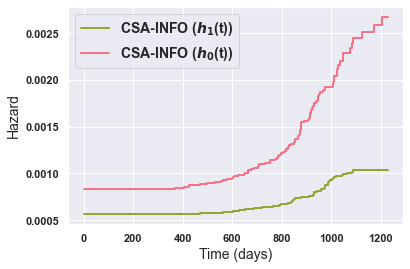

<Figure size 432x288 with 0 Axes>

In [275]:
inv_km_all_0, _, _, _ = compute_km_det(all_T_pred[all_a==0], t_empirical_range=t_emp_range, event=all_e[all_a==0])

inv_km_all_1, _, _, _ = compute_km_det(all_T_pred[all_a==1], t_empirical_range=t_emp_range, event=all_e[all_a==1])

s_0_prime_est = compute_grad(surv=1-inv_km_all_0, time=t_emp_range)
    
s_1_prime_est = compute_grad(surv=1-inv_km_all_1, time=t_emp_range)

HR_est_slope= (1-inv_km_all_0)/(1-inv_km_all_1) * (s_1_prime_est /s_0_prime_est)
hr_dist(HR_est_slope, model + " mean: HR EST Slope " )

colors = sns.color_palette("husl", 4)
plt.xlabel("Time ({})".format(time),  fontsize=fontsize)
plt.ylabel("Hazard",  fontsize=fontsize)

plt.step(t_emp_range, -s_1_prime_est / (1-inv_km_all_1),  label=model+' ($h_1$(t))', lw=2,
         color=colors[1])
plt.step(t_emp_range, -s_0_prime_est / (1-inv_km_all_0),  label=model+' ($h_0$(t))', lw=2,
        color=colors[0])


plt.legend(loc='best', fontsize=legend_size)
plt.show()
plt.tight_layout()




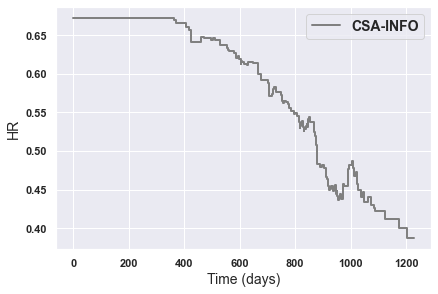

In [276]:
plt.step(t_emp_range, HR_est_slope, label=model, lw=2, color='grey')
plt.tight_layout()
plt.legend(loc='best', fontsize=legend_size)
plt.xlabel("Time ({})".format(time),  fontsize=fontsize)
plt.ylabel("HR",  fontsize=fontsize)
plt.show()


## Investigate Empirical approximation

km_surv:  0.23961235783361126
km_surv:  0.4367919583276423
slope:  -0.000849871085921708 std_err:  9.971206567422655e-06
slope:  -0.0006080467789591755 std_err:  1.0583697849376591e-05
EMP mean: HR EST Slope  0.52 (0.39, 0.71)


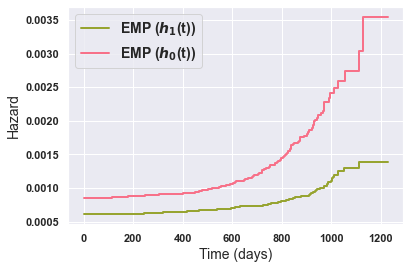

<Figure size 432x288 with 0 Axes>

In [277]:
inv_km_all_0_emp, _, _, _ = compute_km_det(all_Y[all_a==0], t_empirical_range=t_emp_range, event=all_e[all_a==0])

inv_km_all_1_emp, _, _, _ = compute_km_det(all_Y[all_a==1], t_empirical_range=t_emp_range, event=all_e[all_a==1])

s_0_prime_est_emp = compute_grad(surv=1-inv_km_all_0_emp, time=t_emp_range)
    
s_1_prime_est_emp = compute_grad(surv=1-inv_km_all_1_emp, time=t_emp_range)

HR_est_slope_emp= (1-inv_km_all_0_emp)/(1-inv_km_all_1_emp) * (s_1_prime_est_emp /s_0_prime_est_emp)
hr_dist(HR_est_slope_emp, "EMP mean: HR EST Slope ")

colors = sns.color_palette("husl", 4)
plt.xlabel("Time ({})".format(time),  fontsize=fontsize)
plt.ylabel("Hazard",  fontsize=fontsize)

plt.step(t_emp_range, -s_1_prime_est_emp / (1-inv_km_all_1_emp),  label='EMP ($h_1$(t))', lw=2,
         color=colors[1])
plt.step(t_emp_range, -s_0_prime_est_emp / (1-inv_km_all_0_emp),  label='EMP ($h_0$(t))', lw=2,
        color=colors[0])


plt.legend(loc='best', fontsize=legend_size)
plt.show()
plt.tight_layout()


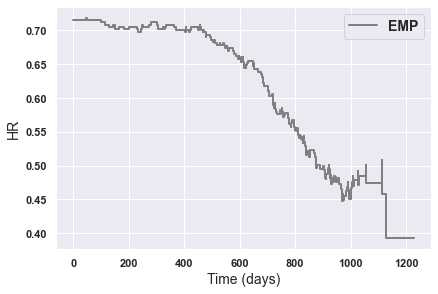

In [278]:
plt.step(t_emp_range, HR_est_slope_emp, label='EMP', lw=2, color='grey')
plt.tight_layout()
plt.legend(loc='best', fontsize=legend_size)
plt.xlabel("Time ({})".format(time),  fontsize=fontsize)
plt.ylabel("HR",  fontsize=fontsize)
plt.show()


## Compare Models

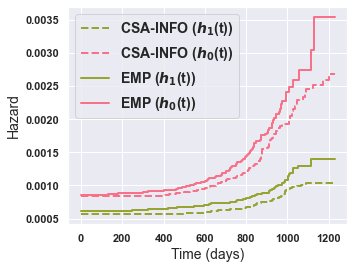

<Figure size 432x288 with 0 Axes>

In [279]:
colors = sns.color_palette("husl", 4)
fig=plt.figure(figsize=(5,4))
plt.xlabel("Time ({})".format(time),  fontsize=fontsize)
plt.ylabel("Hazard",  fontsize=fontsize)


plt.step(t_emp_range, -s_1_prime_est / (1-inv_km_all_1),  label=model+' ($h_1$(t))', lw=2,
         color=colors[1],  linestyle='--')
plt.step(t_emp_range, -s_0_prime_est / (1-inv_km_all_0),  label=model+' ($h_0$(t))', lw=2,
        color=colors[0],  linestyle='--')

plt.step(t_emp_range, -s_1_prime_est_emp / (1-inv_km_all_1_emp),  label='EMP ($h_1$(t))', lw=2,
         color=colors[1])
plt.step(t_emp_range, -s_0_prime_est_emp / (1-inv_km_all_0_emp),  label='EMP ($h_0$(t))', lw=2,
        color=colors[0])



plt.legend(loc='best', fontsize=legend_size)
plt.show()
plt.tight_layout()

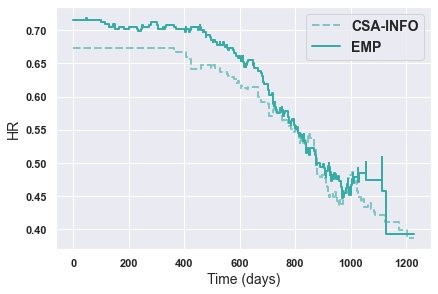

In [280]:
np.save(main_path + model + '_hr', HR_est_slope )
np.save(main_path + 'emp' + '_hr', HR_est_slope_emp )
plt.step(t_emp_range, HR_est_slope, label=model, lw=2, color=colors[2], linestyle='--', alpha=0.6)
plt.step(t_emp_range, HR_est_slope_emp, label="EMP", lw=2, color=colors[2])
plt.tight_layout()
plt.legend(loc='best', fontsize=legend_size)
plt.xlabel("Time ({})".format(time),  fontsize=fontsize)
plt.ylabel("HR",  fontsize=fontsize)
plt.show()